<a href="https://colab.research.google.com/github/salminadia/nadia-salmi/blob/master/2xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

# Colab library to upload files to notebook
from google.colab import files
#Install Kaggle library
!pip install -q kaggle

In [0]:
#Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "nadiasalmi" # username from the json file
os.environ['KAGGLE_KEY'] = "111559c83d6fb4454e6c3764f5976b64" # key from the json file
!kaggle competitions download -c microsoft-malware-prediction # api copied from kaggle

 98% 753M/768M [00:03<00:00, 232MB/s]
100% 768M/768M [00:04<00:00, 200MB/s]
 81% 109M/134M [00:00<00:00, 126MB/s] 
100% 134M/134M [00:00<00:00, 197MB/s]
 97% 651M/672M [00:04<00:00, 188MB/s]
100% 672M/672M [00:04<00:00, 171MB/s]


In [3]:
!unzip sample_submission.csv.zip
!unzip test.csv.zip
!unzip train.csv.zip

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
# en raison des limitations de la mémoire de  et de l'énorme taille du jeu de données, un échantillon de l'ensemble
train_sample_fraction = 0.2


# Valeurs NA qui dépassent ce taux
na_rate_threshold = 0.9

#seuil pour supprimer les colonnes avec des caractéristiques déséquilibrées à leurs valeurs 
unbalanced_feature_rate_threshold = 0.9


In [0]:
#l'idée principale de charger le jeu de données et d'économiser de l'espace mémoire !!
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
%%time
train = pd.read_csv('train.csv', dtype=dtypes)

CPU times: user 2min 24s, sys: 5.59 s, total: 2min 30s
Wall time: 2min 30s


In [0]:
good_cols = list(train.columns)

for col in train.columns:
    
# supprimer les colonnes avec un taux NA élevé
    na_rate = train[col].isnull().sum() / train.shape[0]
    
    # supprimer les colonnes avec un taux élevé de valeurs asymétriques
    unbalanced_rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    
    if na_rate > na_rate_threshold:
        good_cols.remove(col)
    elif unbalanced_rate > unbalanced_feature_rate_threshold:
        good_cols.remove(col)

In [8]:
good_cols

['MachineIdentifier',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IeVerIdentifier',
 'SmartScreen',
 'Census_MDC2FormFactor',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_TotalPhysicalRAM',
 'Census_ChassisTypeName',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_PowerPlatformRoleName',
 'Census_InternalBatteryType',
 'Census_InternalBatteryNumberOfCharges',
 'Census_OSVersion

In [0]:
train = train[good_cols]

In [10]:
import gc

gc.collect()

0

In [0]:
categorical_columns = list(train.loc[:, train.dtypes =="category"].columns)
numerical_and_binary_columns = list(train.loc[:, train.dtypes !="category"].columns)
numerical_columns = numerical_and_binary_columns

categorical_columns.remove("MachineIdentifier")

binary_columns = []
for col in (numerical_and_binary_columns):
    if train[col].nunique() == 2:
        binary_columns.append(col)
        numerical_columns.remove(col)

In [0]:
import gc
train_sample = train.sample(frac=train_sample_fraction, random_state=42)



In [13]:
train_sample.shape

(1784297, 57)

In [0]:
test_dtypes = {k: v for k, v in dtypes.items() if k in good_cols}

# get all columns except
test = pd.read_csv('test.csv', dtype=test_dtypes, usecols=good_cols[:-1])

#test = reduce_mem_usage(test)

In [0]:
#supprission des targets pour faciliter l'encoding
train_sample = train_sample.drop(['MachineIdentifier'], axis=1)
test = test.drop(['MachineIdentifier'], axis=1)

In [0]:
train_sample = train_sample.reset_index(drop=True)

In [0]:
#Remplir les valeurs NA avec le mode statistique
modes = train_sample.mode()

for col in train_sample.columns:
    train_sample[col] = np.where(train_sample[col].isnull(), modes[col], train_sample[col])

del modes

In [0]:
#Remplir les valeurs NA avec le mode statistique
modes_test = test.mode()

for col in test.columns:
    test[col] = np.where(test[col].isnull(), modes_test[col], test[col])

#train_sample.shape
del modes_test

In [19]:
train_sample.shape

(1784297, 56)

In [20]:
test.shape

(7853253, 55)

In [0]:
#Encoder les fonctionnalités catégorielles (train)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def MultiLabelEncoder(columnlist,dataframe):
    for i in columnlist:
        #print(i)
        labelencoder_X=LabelEncoder()
        dataframe[i]=labelencoder_X.fit_transform(dataframe[i])

MultiLabelEncoder(categorical_columns, train_sample)

In [0]:
#Encoder les fonctionnalités catégorielles(test)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def MultiLabelEncoder(columnlist,dataframe):
    for i in columnlist:
        #print(i)
        labelencoder_X=LabelEncoder()
        dataframe[i]=labelencoder_X.fit_transform(dataframe[i])

MultiLabelEncoder(categorical_columns, test)

In [0]:
import numpy as np 
import pandas as pd 
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score,  precision_score, recall_score, confusion_matrix
import xgboost as xgb

In [0]:
train_cols = [c for c in train_sample.columns if c not in ["HasDetections"]]
y_train = train_sample["HasDetections"]

In [25]:
y_train.value_counts()

0    893061
1    891236
Name: HasDetections, dtype: int64

In [0]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1001)

In [0]:

params = {'tree_method': 'hist',
          #régression logistique pour la classification binaire, probabilité de sortie
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'learning_rate': 0.0936165921314771,
 'max_depth': 2,
 'colsample_bytree': 0.3561271102144279,
 'subsample': 0.8246604621518232,
 'min_child_weight': 53,
 'gamma': 9.943467991283027,
 'silent': 1}

In [28]:
%%time

oof_preds = np.zeros(train_sample.shape[0])
sub_preds = np.zeros(test.shape[0])

feature_importance_df = pd.DataFrame()

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_sample, y_train)):
    
    trn_x, trn_y = train_sample[train_cols].iloc[trn_idx], y_train.iloc[trn_idx]
    val_x, val_y = train_sample[train_cols].iloc[val_idx], y_train.iloc[val_idx]
    
    dtrain = xgb.DMatrix(trn_x, trn_y, feature_names=trn_x.columns)
    dval = xgb.DMatrix(val_x, val_y, feature_names=val_x.columns)
    
    clf = xgb.train(params=params, dtrain=dtrain, num_boost_round=4000, evals=[(dtrain, "Train"), (dval, "Val")],
        verbose_eval= 100, early_stopping_rounds=50) 
    
    oof_preds[val_idx] = clf.predict(xgb.DMatrix(val_x))
    sub_preds += clf.predict(xgb.DMatrix(test[train_cols])) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = pd.DataFrame.from_dict(data=clf.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
    fold_importance_df["fscore"] = pd.DataFrame.from_dict(data=clf.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('\nFold %1d AUC %.6f & std %.6f' %(n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx]), np.std([oof_preds[val_idx]])))
    print('Fold %1d Precision %.6f' %(n_fold + 1, precision_score(val_y, np.round(oof_preds[val_idx])) ))
    print('Fold %1d Recall %.6f' %(n_fold + 1, recall_score(val_y, np.round(oof_preds[val_idx]) )))
    print('Fold %1d F1 score %.6f' % (n_fold + 1,f1_score(val_y, np.round(oof_preds[val_idx]))))
    #print('Fold %1d Kappa score %.6f\n' % (n_fold + 1,cohen_kappa_score(val_y, np.round(oof_preds[val_idx]))))
    gc.collect()

print('\nCV AUC score %.6f & std %.6f' % (roc_auc_score(y_train, oof_preds), np.std((oof_preds))))
print('CV Precision score %.6f' % (precision_score(y_train, np.round(oof_preds))))
print('CV Recall score %.6f' % (recall_score(y_train, np.round(oof_preds))))
print('CV F1 score %.6f' % (f1_score(y_train, np.round(oof_preds))))


[0]	Train-auc:0.58549	Val-auc:0.584267
Multiple eval metrics have been passed: 'Val-auc' will be used for early stopping.

Will train until Val-auc hasn't improved in 50 rounds.
[100]	Train-auc:0.685454	Val-auc:0.683122
[200]	Train-auc:0.691776	Val-auc:0.689482
[300]	Train-auc:0.695275	Val-auc:0.693034
[400]	Train-auc:0.697553	Val-auc:0.695322
[500]	Train-auc:0.699634	Val-auc:0.697447
[600]	Train-auc:0.701072	Val-auc:0.698842
[700]	Train-auc:0.702374	Val-auc:0.700149
[800]	Train-auc:0.703658	Val-auc:0.701427
[900]	Train-auc:0.704832	Val-auc:0.702628
[1000]	Train-auc:0.705654	Val-auc:0.703427
[1100]	Train-auc:0.706473	Val-auc:0.704174
[1200]	Train-auc:0.707076	Val-auc:0.704794
[1300]	Train-auc:0.707728	Val-auc:0.705425
[1400]	Train-auc:0.708234	Val-auc:0.705931
[1500]	Train-auc:0.708629	Val-auc:0.706298
[1600]	Train-auc:0.709048	Val-auc:0.706701
[1700]	Train-auc:0.709484	Val-auc:0.707104
[1800]	Train-auc:0.709851	Val-auc:0.707487
[1900]	Train-auc:0.710127	Val-auc:0.707731
[2000]	Train-a

[[583865 309196]
 [313453 577783]]


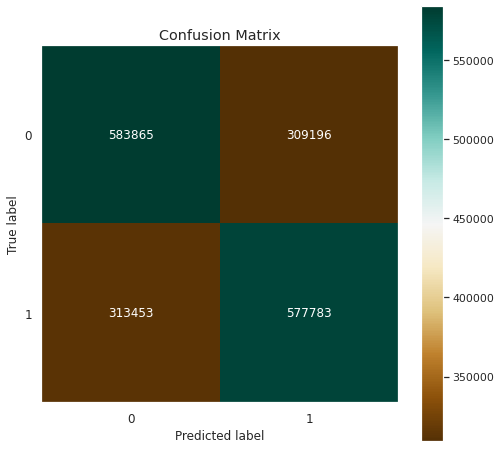

In [0]:
print(confusion_matrix(y_train, np.round(oof_preds)))
skplt.metrics.plot_confusion_matrix(y_train, np.round(oof_preds), cmap="BrBG")

In [0]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(val_y, oof_preds, cmap="BrBG")

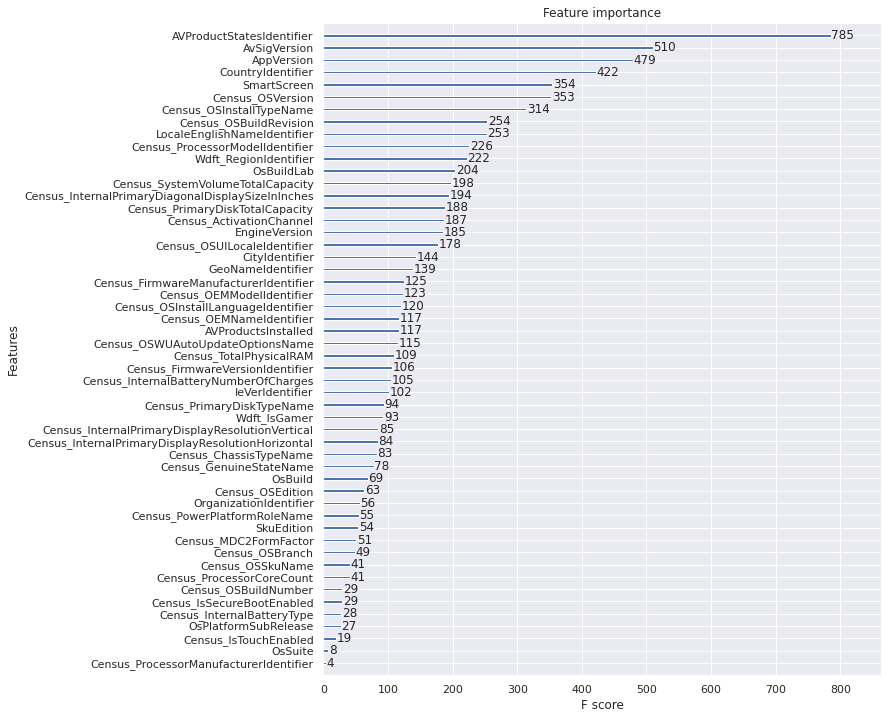

In [0]:
fig, ax = plt.subplots(1,1,figsize=(10,12)) 
xgb.plot_importance(clf, max_num_features=57, ax=ax)  

In [0]:
test['HasDetections'] = sub_preds

In [0]:
test.head()

,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,68,70,9261,53447.0,1.0,43,58552.0,18.0,53.0,42,15063,768,2,259,4,108.0,13,8,2688.0,30661.0,4.0,5.0,3064.0,488386.0,1,123179.0,8192.0,33,15.500000,1920.0,1080.0,3,42,8.0,255,3,15063,1387,4,2,5,37.0,158,0,1,0,0.0,0.0,807.0,8554.0,1,0.0,0,0.0,7.0,0.623209
1,67,64,9005,53447.0,1.0,68,71395.0,27.0,276.0,74,16299,768,3,270,4,117.0,13,8,2206.0,242491.0,4.0,5.0,3410.0,1907729.0,0,1882352.0,8192.0,33,15.500000,1366.0,768.0,3,42,0.0,323,6,16299,611,4,2,6,7.0,30,0,1,2,0.0,0.0,554.0,33105.0,1,0.0,0,1.0,12.0,0.662946
2,65,64,8501,49480.0,2.0,201,66202.0,27.0,267.0,-5,14393,768,1,201,4,98.0,13,8,585.0,189533.0,2.0,5.0,2096.0,29820.0,1,28678.0,4096.0,33,13.898438,1280.0,720.0,3,42,0.0,174,0,14393,2189,7,5,3,35.0,148,5,1,0,0.0,0.0,556.0,63396.0,1,0.0,0,1.0,11.0,0.520969
3,68,70,9301,42160.0,2.0,29,120917.0,27.0,35.0,-85,16299,768,3,266,4,117.0,13,8,2668.0,171228.0,2.0,5.0,1985.0,476940.0,0,439345.0,4096.0,33,14.000000,1366.0,768.0,3,37,0.0,312,5,16299,371,7,5,8,26.0,119,3,1,0,0.0,0.0,628.0,26320.0,1,0.0,0,0.0,10.0,0.414077
4,67,64,8989,53447.0,1.0,171,124736.0,18.0,211.0,-74,16299,768,3,266,4,117.0,13,8,585.0,189538.0,4.0,5.0,3394.0,476940.0,0,461506.0,2048.0,33,15.500000,1366.0,768.0,3,42,0.0,312,5,16299,371,7,5,7,29.0,125,5,1,2,0.0,0.0,556.0,63269.0,1,0.0,0,1.0,3.0,0.602327


In [0]:

oof_roc = roc_auc_score(y_train, oof_preds)
oof_roc 

0.7122472107766223

In [0]:
import os

In [0]:
os.environ['COLAB_TPU_ADDR']

'10.14.77.90:8470'

In [0]:
!jupyter nbconvert --to html nadia.ipynb

La construction de model 1


In [28]:
%%time

oof_preds = np.zeros(train_sample.shape[0])
sub_preds = np.zeros(test.shape[0])

feature_importance_df = pd.DataFrame()

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_sample, y_train)):
    
    trn_x, trn_y = train_sample[train_cols].iloc[trn_idx], y_train.iloc[trn_idx]
    val_x, val_y = train_sample[train_cols].iloc[val_idx], y_train.iloc[val_idx]
    
    dtrain = xgb.DMatrix(trn_x, trn_y, feature_names=trn_x.columns)
    dval = xgb.DMatrix(val_x, val_y, feature_names=val_x.columns)
    
    clf = xgb.train(params=params, dtrain=dtrain, num_boost_round=1000, evals=[(dtrain, "Train"), (dval, "Val")],
        verbose_eval= 100, early_stopping_rounds=100) 
    
    oof_preds[val_idx] = clf.predict(xgb.DMatrix(val_x))
    sub_preds += clf.predict(xgb.DMatrix(test[train_cols])) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = pd.DataFrame.from_dict(data=clf.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
    fold_importance_df["fscore"] = pd.DataFrame.from_dict(data=clf.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('\nFold %1d AUC %.6f & std %.6f' %(n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx]), np.std([oof_preds[val_idx]])))
    print('Fold %1d Precision %.6f' %(n_fold + 1, precision_score(val_y, np.round(oof_preds[val_idx])) ))
    print('Fold %1d Recall %.6f' %(n_fold + 1, recall_score(val_y, np.round(oof_preds[val_idx]) )))
    print('Fold %1d F1 score %.6f' % (n_fold + 1,f1_score(val_y, np.round(oof_preds[val_idx]))))
    #print('Fold %1d Kappa score %.6f\n' % (n_fold + 1,cohen_kappa_score(val_y, np.round(oof_preds[val_idx]))))
    gc.collect()

print('\nCV AUC score %.6f & std %.6f' % (roc_auc_score(y_train, oof_preds), np.std((oof_preds))))
print('Cross validation Precision score %.6f' % (precision_score(y_train, np.round(oof_preds))))
print('Cross validation Recall score %.6f' % (recall_score(y_train, np.round(oof_preds))))
print('Cross validation F1 score %.6f' % (f1_score(y_train, np.round(oof_preds))))


[0]	Train-auc:0.58549	Val-auc:0.584267
Multiple eval metrics have been passed: 'Val-auc' will be used for early stopping.

Will train until Val-auc hasn't improved in 100 rounds.
[100]	Train-auc:0.685454	Val-auc:0.683122
[200]	Train-auc:0.691776	Val-auc:0.689482
[300]	Train-auc:0.695275	Val-auc:0.693034
[400]	Train-auc:0.697553	Val-auc:0.695322
[500]	Train-auc:0.699634	Val-auc:0.697447
[600]	Train-auc:0.701072	Val-auc:0.698842
[700]	Train-auc:0.702374	Val-auc:0.700149
[800]	Train-auc:0.703658	Val-auc:0.701427
[900]	Train-auc:0.704832	Val-auc:0.702628
[999]	Train-auc:0.705646	Val-auc:0.703418

Fold 1 AUC 0.703418 & std 0.171344
Fold 1 Precision 0.643963
Fold 1 Recall 0.644714
Fold 1 F1 score 0.644338
[0]	Train-auc:0.584858	Val-auc:0.586797
Multiple eval metrics have been passed: 'Val-auc' will be used for early stopping.

Will train until Val-auc hasn't improved in 100 rounds.
[100]	Train-auc:0.684217	Val-auc:0.68571
[200]	Train-auc:0.691212	Val-auc:0.692714
[300]	Train-auc:0.694885	Val

In [29]:
oof_roc = roc_auc_score(y_train, oof_preds)
oof_roc 

0.7047632598654217

In [33]:
! pip install scikit-plot

In [0]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt


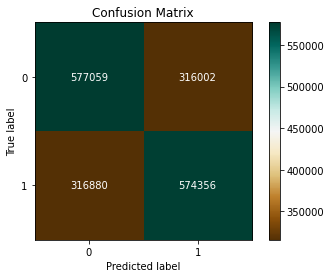

In [41]:
#print(confusion_matrix(y_train, np.round(oof_preds)))
cm=skplt.metrics.plot_confusion_matrix(y_train, np.round(oof_preds), cmap="BrBG")

In [48]:
cm=confusion_matrix(y_train, np.round(oof_preds))
print("False positive rate : %f %%" % ((cm[0][1] / float(sum(cm[0])))*100))
print('False negative rate : %f %%' % ( (cm[1][0] /float(sum(cm[1]))*100)))


False positive rate : 35.384145 %
False negative rate : 35.555117 %


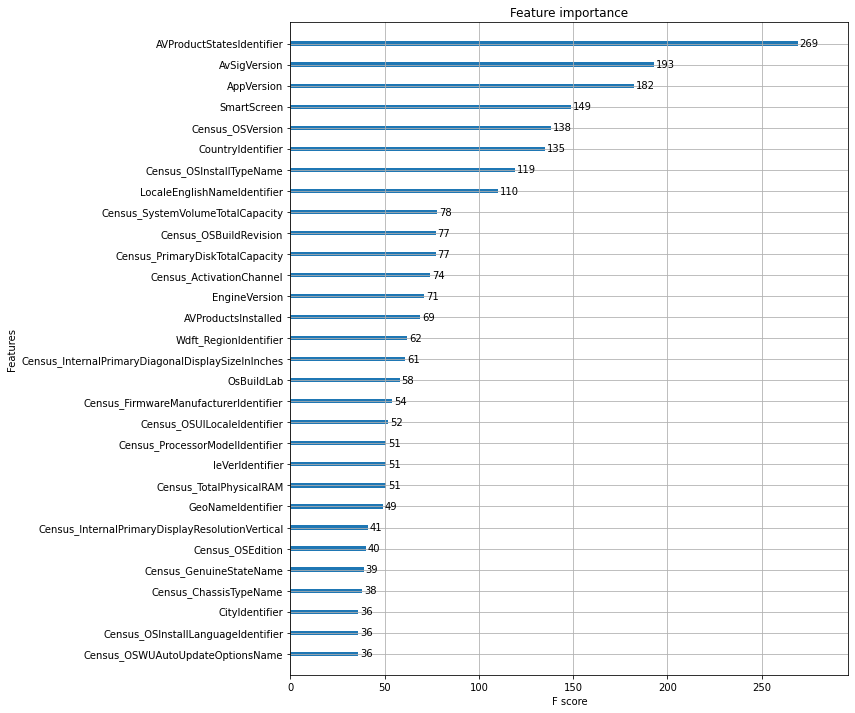

In [38]:
fig, ax = plt.subplots(1,1,figsize=(10,12)) 
xgb.plot_importance(clf, max_num_features=30, ax=ax) 

In [51]:
test['HasDetections'] = sub_preds
test.head()


,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,68,70,9261,53447.0,1.0,43,58552.0,18.0,53.0,42,15063,768,2,259,4,108.0,13,8,2688.0,30661.0,4.0,5.0,3064.0,488386.0,1,123179.0,8192.0,33,15.500000,1920.0,1080.0,3,42,8.0,255,3,15063,1387,4,2,5,37.0,158,0,1,0,0.0,0.0,807.0,8554.0,1,0.0,0,0.0,7.0,0.593659
1,67,64,9005,53447.0,1.0,68,71395.0,27.0,276.0,74,16299,768,3,270,4,117.0,13,8,2206.0,242491.0,4.0,5.0,3410.0,1907729.0,0,1882352.0,8192.0,33,15.500000,1366.0,768.0,3,42,0.0,323,6,16299,611,4,2,6,7.0,30,0,1,2,0.0,0.0,554.0,33105.0,1,0.0,0,1.0,12.0,0.634720
2,65,64,8501,49480.0,2.0,201,66202.0,27.0,267.0,-5,14393,768,1,201,4,98.0,13,8,585.0,189533.0,2.0,5.0,2096.0,29820.0,1,28678.0,4096.0,33,13.898438,1280.0,720.0,3,42,0.0,174,0,14393,2189,7,5,3,35.0,148,5,1,0,0.0,0.0,556.0,63396.0,1,0.0,0,1.0,11.0,0.489733
3,68,70,9301,42160.0,2.0,29,120917.0,27.0,35.0,-85,16299,768,3,266,4,117.0,13,8,2668.0,171228.0,2.0,5.0,1985.0,476940.0,0,439345.0,4096.0,33,14.000000,1366.0,768.0,3,37,0.0,312,5,16299,371,7,5,8,26.0,119,3,1,0,0.0,0.0,628.0,26320.0,1,0.0,0,0.0,10.0,0.331173
4,67,64,8989,53447.0,1.0,171,124736.0,18.0,211.0,-74,16299,768,3,266,4,117.0,13,8,585.0,189538.0,4.0,5.0,3394.0,476940.0,0,461506.0,2048.0,33,15.500000,1366.0,768.0,3,42,0.0,312,5,16299,371,7,5,7,29.0,125,5,1,2,0.0,0.0,556.0,63269.0,1,0.0,0,1.0,3.0,0.573225


In [52]:
oof_roc = roc_auc_score(y_train, oof_preds)
oof_roc 

0.7047632598654217

In [0]:
nadiasalmi = pd.DataFrame({"MachineIdentifier":test["MachineIdentifier"], "HasDetections":test["HasDetections"]})
nadiasalmi.to_csv("nadia_xgb_%sFold_%.6f.csv"%(folds.n_splits, oof_roc), index=None)


In [0]:
submission = pd.read_csv('sample_submission.csv')
submission['HasDetections'] = sub_preds
submission.to_csv('xgboost.csv', index=False)

In [0]:
nadia = pd.read_csv('xgboost.csv')

In [56]:
nadia.shape

(7853253, 2)

In [57]:
nadia.head(5)

,MachineIdentifier,HasDetections
0,0000010489e3af074adeac69c53e555e,0.593659
1,00000176ac758d54827acd545b6315a5,0.634720
2,0000019dcefc128c2d4387c1273dae1d,0.489733
3,0000055553dc51b1295785415f1a224d,0.331173
4,00000574cefffeca83ec8adf9285b2bf,0.573225


In [59]:
!pip install nbconvert

In [0]:
!jupyter nbconvert --to html nadia.ipynb